# PA Approval Prediction
### Xichen Kong
### Team Spruce

## What is done in this notebook
1. Read merged claim data and define X and y
2. Select features using all data
3. Split train and test data and obtain a random subset of train data for tuning
4. Separately tune hyperparameters and select best Logistic Regression and XGBoost model based on F1 score
5. Choose best threshold for each model using train data
6. Generate predictions using test data with selected models and thresholds 
7. Compare performance based on metrics

In [184]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [222]:
from yellowbrick.classifier import DiscriminationThreshold
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.classifier import ROCAUC

In [161]:
# read in merged data
claim = pd.read_csv('claim.csv')
claim.set_index('dim_claim_id', inplace=True)

# keep PA relevant data
claim.dropna(inplace=True)
claim.reset_index(drop=True, inplace=True)

In [30]:
claim.head()

,bin,drug,reject_code,pharmacy_claim_approved,dim_pa_id,dim_date_id,date_val,calendar_year,calendar_month,calendar_day,day_of_week,is_weekday,is_workday,is_holiday,correct_diagnosis,tried_and_failed,contraindication,pa_approved
0,1,A,75.00,0,1.00,1,2017-01-01,2017,1,1,1,0,0,1,1.00,1.00,0.00,1.00
1,3,A,76.00,0,2.00,1,2017-01-01,2017,1,1,1,0,0,1,1.00,0.00,0.00,1.00
2,1,A,75.00,0,3.00,1,2017-01-01,2017,1,1,1,0,0,1,0.00,0.00,1.00,1.00
3,2,A,76.00,0,4.00,1,2017-01-01,2017,1,1,1,0,0,1,1.00,1.00,0.00,1.00
4,4,A,70.00,0,5.00,1,2017-01-01,2017,1,1,1,0,0,1,0.00,1.00,0.00,1.00


In [162]:
# define X and y
X = claim.drop(columns=['dim_pa_id','date_val','reject_code','pharmacy_claim_approved','pa_approved'])
X['drug'] = X['drug'].astype('category').cat.codes
y = claim['pa_approved']

D:\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\envs\ML\lib\site-packages\yellowbrick\model_selection\importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


<AxesSubplot:title={'center':'Feature Importances of 13 Features using LogisticRegression'}, xlabel='relative coefficient magnitude'>

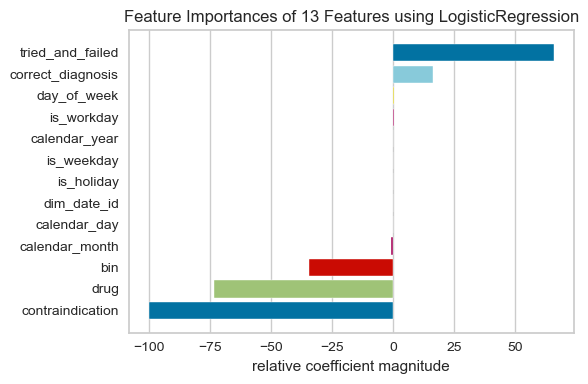

In [81]:
# selecting features
visualizer = FeatureImportances(LogisticRegression(),size=(600, 400))
visualizer.fit(X, y)
visualizer.show(outpath="featureimportancelogit.pdf")

D:\anaconda3\envs\ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:56:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot:title={'center':'Feature Importances of 13 Features using XGBClassifier'}, xlabel='relative importance'>

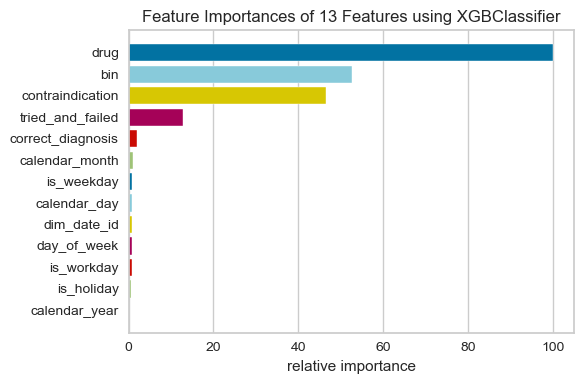

In [82]:
# selecting features
visualizer = FeatureImportances(XGBClassifier(),size=(600, 400))
visualizer.fit(X, y)
visualizer.show(outpath="featureimportancexgb.pdf")

In [163]:
# redefine X
X = X[['drug','bin','contraindication','tried_and_failed','correct_diagnosis']]
X

,drug,bin,contraindication,tried_and_failed,correct_diagnosis
0,0,1,0.00,1.00,1.00
1,0,3,0.00,0.00,1.00
2,0,1,1.00,0.00,0.00
3,0,2,0.00,1.00,1.00
4,0,4,0.00,1.00,0.00
...,...,...,...,...,...
555946,2,1,1.00,0.00,1.00
555947,2,3,1.00,0.00,1.00
555948,2,3,1.00,1.00,1.00
555949,2,3,0.00,0.00,1.00


In [164]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       shuffle = True,
                                                       random_state = 666,
                                                       test_size = .20,
                                                       stratify = y)
print("The shape of X_train is",X_train.shape)
print("The shape of X_test is",X_test.shape)
print("The length of y_train is",len(y_train))
print("The length of y_test is",len(y_test))

The shape of X_train is (444760, 5)
The shape of X_test is (111191, 5)
The length of y_train is 444760
The length of y_test is 111191


In [94]:
# Obtain random subset for tuning 
X_no, X_sub, y_no, y_sub = train_test_split(X_train,y_train,
                                                   shuffle = True,
                                                   random_state = 666,
                                                   test_size = .20,
                                                   stratify = y_train)

In [95]:
# Create kfold object
kfold = StratifiedKFold(n_splits = 5,
                      shuffle = True,
                      random_state = 666)

In [96]:
# tune Logistic Regression model 1
param_grid_logit = [{'penalty' : ['l2','none'],
                'C' : [0.001,0.01,0.1,1,10,100,1000],
                'solver' : ['lbfgs','newton-cg','sag'],}]

logit1 = GridSearchCV(LogisticRegression(), 
                      param_grid = param_grid_logit, 
                      cv = kfold, 
                      scoring='f1',
                      verbose=True, 
                      n_jobs=-1)
logit1.fit(X_sub,y_sub)

logit1.best_score_

Fitting 5 folds for each of 42 candidates, totalling 210 fits


0.8525636543557298

In [97]:
# tune Logistic Regression model 2
param_grid_logit = [{'penalty' : ['l1', 'l2'],
                'C' : [0.001,0.01,0.1,1,10,100,1000],
                'solver' : ['liblinear'],}]

logit2 = GridSearchCV(LogisticRegression(), 
                      param_grid = param_grid_logit, 
                      cv = kfold, 
                      scoring='f1',
                      verbose=True, 
                      n_jobs=-1)
logit2.fit(X_sub,y_sub)

logit2.best_score_

Fitting 5 folds for each of 14 candidates, totalling 70 fits


0.8525674386838358

In [98]:
# tune Logistic Regression model 3
param_grid_logit = [{'penalty' : ['elasticnet','l1','l2','none'],
                'C' : [0.001,0.01,0.1,1,10,100,1000],
                'solver' : ['saga']}]

logit3 = GridSearchCV(LogisticRegression(), 
                      param_grid = param_grid_logit, 
                      cv = kfold, 
                      scoring='f1',
                      verbose=True, 
                      n_jobs=-1)
logit3.fit(X_sub,y_sub)

logit3.best_score_

Fitting 5 folds for each of 28 candidates, totalling 140 fits


D:\anaconda3\envs\ML\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "D:\anaconda3\envs\ML\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py", line 1471, in fit
    raise ValueError(
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn(some_fits_failed_message, FitFailedWarning)
D:\anaconda3\envs\ML\lib\site-packages\sklearn\model_selection\_sea

0.8525636543557298

In [101]:
# choosing logit model
logit = logit2.best_estimator_
logit

LogisticRegression(C=0.01, solver='liblinear')

In [165]:
logit = LogisticRegression(C=0.01, solver='liblinear')

In [99]:
# tune XGBoost model 1
param_grid_xgb = { 'max_depth': [3,6,10],
                  'n_estimators': [100, 500, 1000]}

xgb1 = GridSearchCV(XGBClassifier(),
                      param_grid=param_grid_xgb,
                      cv = kfold,
                      scoring='f1',
                      verbose=True, 
                      n_jobs=-1)
xgb1.fit(X_sub,y_sub)

xgb1.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


D:\anaconda3\envs\ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:12:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8792865563018699

In [100]:
xgb1.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [102]:
# tune XGBoost model 2
param_grid_xgb = { 'max_depth': [3],
                   'learning_rate': [0.01, 0.05, 0.1,0.2,0.3],
                   'n_estimators': [100]}

xgb2 = GridSearchCV(XGBClassifier(),
                      param_grid=param_grid_xgb,
                      cv = kfold,
                      scoring='f1',
                      verbose=True, 
                      n_jobs=-1)
xgb2.fit(X_sub,y_sub)

xgb2.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


D:\anaconda3\envs\ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:13:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8794900320394634

In [103]:
# choosing xgb model
xgb = xgb2.best_estimator_
xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [168]:
xgb = XGBClassifier(learning_rate=0.2, max_depth=3, n_estimators=100)

<AxesSubplot:title={'center':'Threshold Plot for LogisticRegression'}, xlabel='discrimination threshold', ylabel='score'>

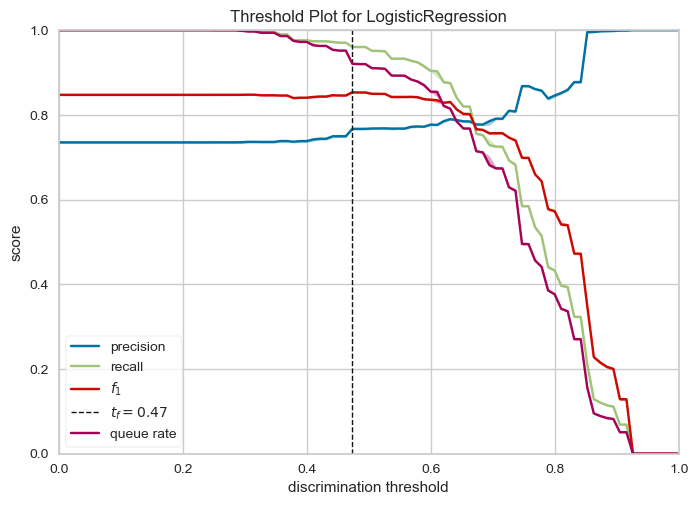

In [104]:
# choosing threshold for logit 
visualizer = DiscriminationThreshold(logit)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    visualizer.fit(X_train, y_train)
    
visualizer.show(outpath="thresholdlogit.pdf")

In [199]:
cutoff_logit = 0.7

[13:14:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:14:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:14:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:14:55] WARNING:

[13:17:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:17:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:17:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:17:50] WARNING:

<AxesSubplot:title={'center':'Threshold Plot for XGBClassifier'}, xlabel='discrimination threshold', ylabel='score'>

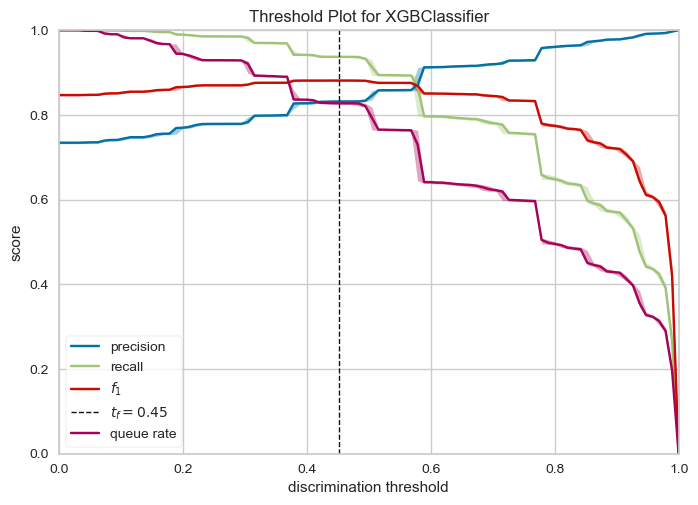

In [105]:
# choosing threshold for xgb 
visualizer = DiscriminationThreshold(xgb)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    visualizer.fit(X_train, y_train)
    
visualizer.show(outpath="thresholdxgb.pdf")

In [200]:
cutoff_xgb = 0.75

In [214]:
# making predictions
logit.fit(X_train,y_train)
pred_logit = 1*(logit.predict_proba(X_test)[:,1] >= cutoff_logit)
cm_logit = confusion_matrix(y_test, pred_logit)

xgb.fit(X_train,y_train)
pred_xgb = 1*(xgb.predict_proba(X_test)[:,1] >= cutoff_xgb)
cm_xgb = confusion_matrix(y_test, pred_xgb)

df_cm_logit = pd.DataFrame({'Actual Class': ['0','1'],
                           'Predicted 0': cm_logit[:,0],
                           'Predicted 1': cm_logit[:,1]})
df_cm_xgb = pd.DataFrame({'Actual Class': ['0','1'],
                           'Predicted 0': cm_xgb[:,0],
                           'Predicted 1': cm_xgb[:,1]})

print("Confusion Matrix for Logistic Regression")
print(cm_logit)
print("Confusion Matrix for XGBoost")
print(cm_xgb)

D:\anaconda3\envs\ML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:02:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix for Logistic Regression
[[13759 15768]
 [22286 59378]]
Confusion Matrix for XGBoost
[[24570  4957]
 [19760 61904]]


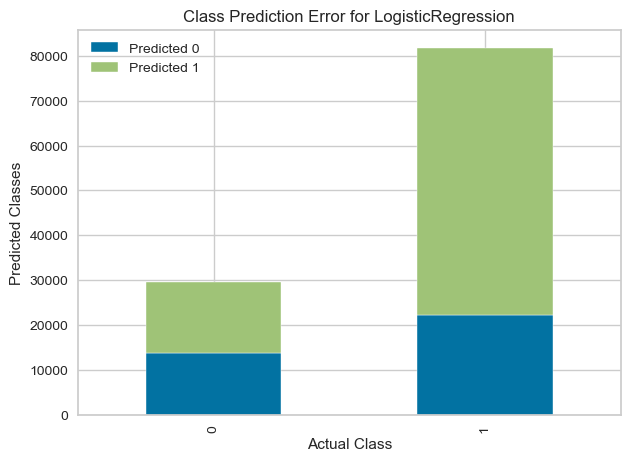

In [215]:
# prediction errors for logit 
fig, ax = plt.subplots(figsize=(7, 5))

df_cm_logit.plot(x='Actual Class', kind='bar', stacked=True, ax=ax)

plt.title('Class Prediction Error for LogisticRegression')
plt.xlabel('Actual Class')
plt.ylabel('Predicted Classes')
plt.savefig('errorlogit.pdf')

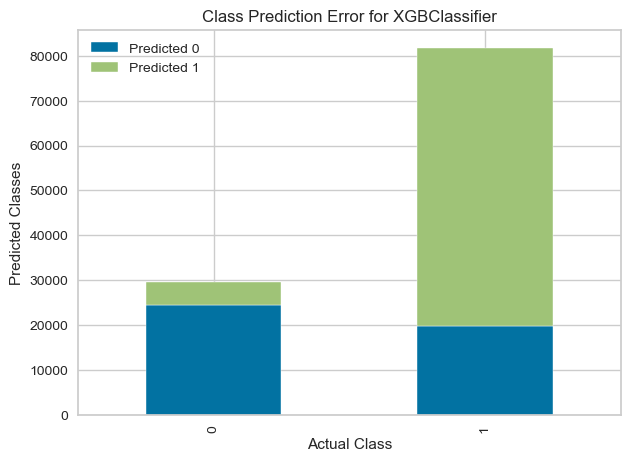

In [216]:
# prediction errors for xgb 
fig, ax = plt.subplots(figsize=(7, 5))

df_cm_xgb.plot(x='Actual Class', kind='bar', stacked=True, ax=ax)

plt.title('Class Prediction Error for XGBClassifier')
plt.xlabel('Actual Class')
plt.ylabel('Predicted Classes')
plt.savefig('errorxgb.pdf')

D:\anaconda3\envs\ML\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

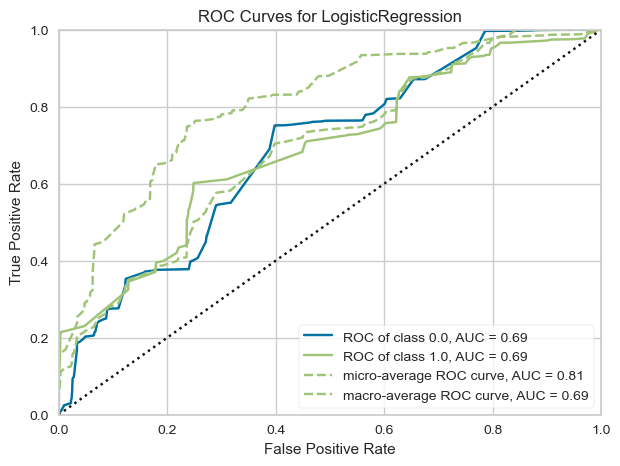

In [235]:
# ROC Curve and AUC for logit 
plt.figure(figsize=(7,5))
plt.title("ROC Curve and AUC", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

visualizer = ROCAUC(logit)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show(outpath='auclogit.pdf') 

<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

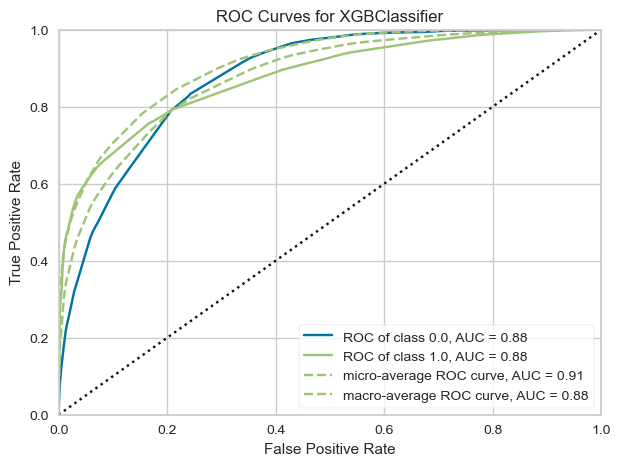

In [234]:
# ROC Curve and AUC for xgb 
plt.figure(figsize=(7,5))
plt.title("ROC Curve and AUC", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

visualizer = ROCAUC(xgb)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show(outpath='aucxgb.pdf') 